In [1]:
!python -V

Python 3.9.16


In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl

## Q1. Downloading the data

We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page),
but instead of "**Green** Taxi Trip Records", we'll use "**Yellow** Taxi Trip Records".

Download the data for January and February 2022.

Read the data for January. How many columns are there?

* 16
* 17
* 18
* 19

In [3]:
df_january = pd.read_parquet("./data/yellow_tripdata_2022-01.parquet")
print("Column Count: ", len(df_january.columns))

Column Count:  19


## Q2. Computing duration

Now let's compute the `duration` variable. It should contain the duration of a ride in minutes. 

What's the standard deviation of the trips duration in January?

* 41.45
* 46.45
* 51.45
* 56.45

In [4]:
len(df_january.index)

2463931

In [5]:
df_january.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

In [6]:
df_january['duration'] = df_january.tpep_dropoff_datetime - df_january.tpep_pickup_datetime     
df_january.duration = df_january.duration.apply(lambda td: td.total_seconds() / 60) 
df_january.duration.std().round(2)

46.45


## Q3. Dropping outliers

Next, we need to check the distribution of the `duration` variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

* 90%
* 92%
* 95%
* 98%

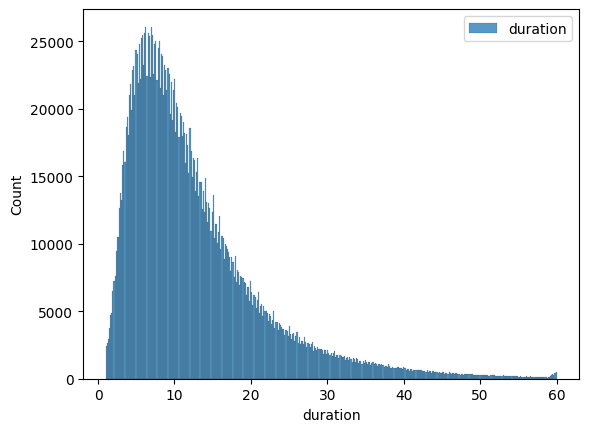

In [7]:
df_january_cleaned = df_january[(df_january.duration >= 1) & (df_january.duration <= 60)]
sns.histplot(df_january_cleaned.duration, label='duration')
plt.legend()

In [8]:
fraction = (len(df_january_cleaned) / len(df_january))
print("Fraction of the recors left after cleaning: ",fraction* 100,"%")

Fraction of the recors left after cleaning:  98.27547930522405 %


## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model. 

* Turn the dataframe into a list of dictionaries
* Fit a dictionary vectorizer 
* Get a feature matrix from it

What's the dimensionality of this matrix (number of columns)?

* 2
* 155
* 345
* 515
* 715

In [9]:
# PULocationID,  DOLocationID
df_train = df_january_cleaned
categorical = ['PULocationID', 'DOLocationID']
df_train[categorical] = df_train[categorical].astype(str)
df_train_cat = df_train[categorical] 
df_train_cat

/tmp/ipykernel_4146/2066886058.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[categorical] = df_train[categorical].astype(str)


,PULocationID,DOLocationID
0,142,236
1,236,42
2,166,166
3,114,68
4,68,163
...,...,...
2463926,90,170
2463927,107,75
2463928,113,246
2463929,148,164


#df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']

from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)


In [33]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(df_train_cat)
df_train_cat_onehotlabels = ohe.transform(df_train_cat)
df_train_cat_onehotlabels.shape

(2421440, 515)

## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model. 

* Train a plain linear regression model with default parameters 
* Calculate the RMSE of the model on the training data

What's the RMSE on train?

* 6.99
* 11.99
* 16.99
* 21.99

In [14]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

target = 'duration'
y_train = df_train[target].values

lr.fit(df_train_cat_onehotlabels, y_train)

LinearRegression()

In [15]:
y_pred = lr.predict(df_train_cat_onehotlabels)

In [16]:
y_pred.shape

(2421440,)

In [18]:
skl.metrics.mean_squared_error(y_train, y_pred, squared=False)

6.986190831662192

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2022). 

What's the RMSE on validation?

* 7.79
* 12.79
* 17.79
* 22.79

In [30]:
raw_data = pd.read_parquet('./data/yellow_tripdata_2022-02.parquet')

In [34]:
raw_data['duration'] = raw_data.tpep_dropoff_datetime - raw_data.tpep_pickup_datetime     
raw_data.duration = raw_data.duration.apply(lambda td: td.total_seconds() / 60) 
raw_data = raw_data[(raw_data.duration >= 1) & (raw_data.duration <= 60)]
categorical = ['PULocationID', 'DOLocationID']
raw_data[categorical] = raw_data[categorical].astype(str)
raw_data_cat = raw_data[categorical] 
df_train_cat_onehotlabels = ohe.transform(raw_data_cat)
df_train_cat_onehotlabels


<2918187x515 sparse matrix of type '<class 'numpy.float64'>'
	with 5836368 stored elements in Compressed Sparse Row format>

In [35]:
df_train_cat_onehotlabels.shape

(2918187, 515)

In [36]:
y_pred_val = lr.predict(df_train_cat_onehotlabels)

In [38]:
skl.metrics.mean_squared_error(raw_data[target].values, y_pred_val, squared=False)

7.786407584284582